In [1]:
import gsw
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Cluster visualization

In [2]:
# load clustered data
df = pd.read_csv("df_s_60.csv")  # or df_s.csv (cluster removal by automatic elbow method)

In [4]:
# compute density
df["pressure"] = gsw.p_from_z(-1*df["LEV_M"], df["LATITUDE"])
df["abs_salinity"] = gsw.SA_from_SP(df["P_SALINITY"], df["pressure"], df["LONGITUDE"], df["LATITUDE"])
df["cons_temperature"] = gsw.CT_from_pt(df["abs_salinity"], df["P_TEMPERATURE"])
df["rho"] = gsw.rho(df["abs_salinity"], df["cons_temperature"], df["pressure"])

In [5]:
# Figure out boudaries (mins and maxs)
smin = df["abs_salinity"].min() - (5 * df["abs_salinity"].min())
smax = df["abs_salinity"].max() + (0.01 * df["abs_salinity"].max())
tmin = df["cons_temperature"].min() - (0.1 * df["cons_temperature"].max())
tmax = df["cons_temperature"].max() + (0.1 * df["cons_temperature"].max())

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax - smin) / 0.1 + 1, 0))
ydim = int(round((tmax - tmin) + 1, 0))

# Create empty grid of zeros
dens = np.zeros((ydim, xdim))

# Create temp and salt vectors of appropriate dimensions
si = np.linspace(1, xdim - 1, xdim) * 0.1 + smin
ti = np.linspace(1, ydim - 1, ydim) + tmin

# Loop to fill in grid with densities
for j in range(0, int(ydim)):
    for i in range(0, int(xdim)):
        dens[j, i] = gsw.rho(si[i], ti[j], 0)

# Subtract 1000 to convert to sigma-t
dens = dens - 1000

# basemap for plot
map = Basemap(llcrnrlon=df["LONGITUDE"].min(), llcrnrlat=df["LATITUDE"].min(),
              urcrnrlon=df["LONGITUDE"].max(), urcrnrlat=df["LATITUDE"].max())


# Overall plots

In [9]:
%matplotlib widget

# plots TS
fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(111)
CS = plt.contour(si, ti, dens, linestyles='dashed', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%1.0f')  # Label every second level
ax1.scatter(x=df["abs_salinity"], y=df["cons_temperature"], s=9, c=df["color"], alpha=0.1, marker=".")
ax1.set_xlabel('Absolute salinity [k/kg]')
ax1.set_ylabel('Conservative temperature [°C]')
# ax1.set_xlim(32, 40)
plt.show()

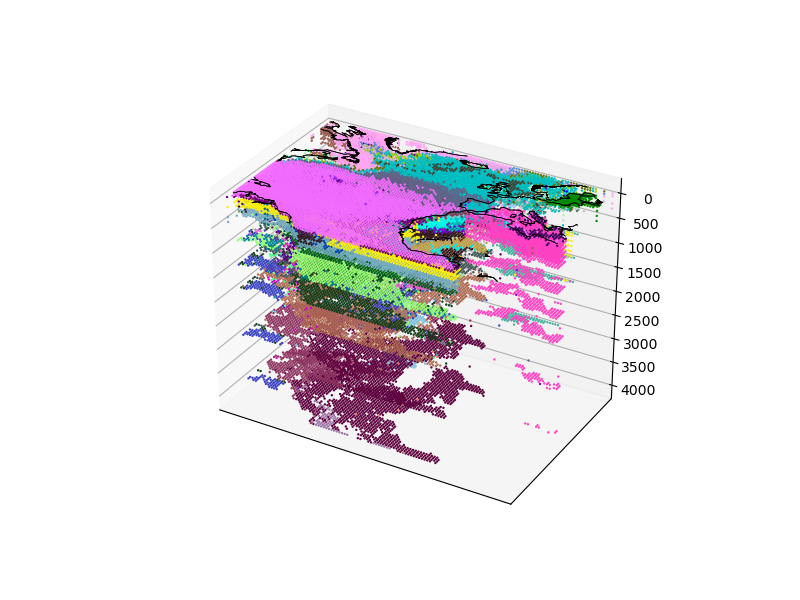

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(df["LONGITUDE"], df["LATITUDE"], df["LEV_M"], color=df["color"], s=2, alpha=1, marker=".")
ax.add_collection3d(map.drawcoastlines(linewidth=0.5))
ax.set_box_aspect((np.ptp(df["LONGITUDE"]), np.ptp(df["LATITUDE"]),
                   np.ptp(df["LEV_M"]) / 50))  # aspect ratio is 1:1:1 in data space
plt.gca().invert_zaxis()
plt.show()

In [13]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df["e0"], df["e1"], df["e2"], c=df["color"], alpha=0.8, s=1)  # , s=s, alpha=1, zorder=4)
plt.show(block=True)

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 1)

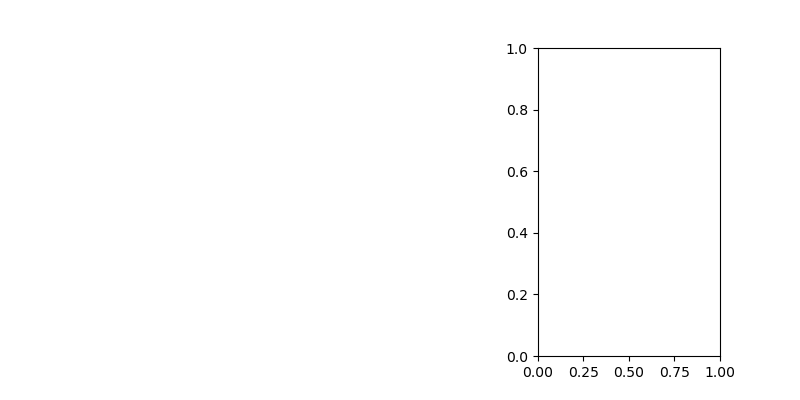

In [41]:
# plot figures per cluster
alpha = 0.2
for label in [412]:  # df["labels"].unique():
    temp = df[df["labels"] == label]
    # li = ["412", "622", "470", "520", "450", "409", "462"]  # "375", "291", "508",

    # Figure out boudaries (mins and maxs)
    smin = temp["abs_salinity"].min()# - (0.01 * temp["abs_salinity"].min())
    smax = temp["abs_salinity"].max()# + (0.01 * temp["abs_salinity"].max())
    tmin = temp["cons_temperature"].min()# - (0.2 * temp["cons_temperature"].max())
    tmax = temp["cons_temperature"].max()# + (0.2 * temp["cons_temperature"].max())

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax - smin)))# / 0.1 + 1, 0))
    ydim = int(round((tmax - tmin)))# + 1, 0))

    # Create empty grid of zeros
    dens = np.zeros((ydim, xdim))

    # Create temp and salt vectors of appropriate dimensions
    si = np.linspace(1, xdim - 1, xdim) * 0.1 + smin
    ti = np.linspace(1, ydim - 1, ydim) + tmin

    # Loop to fill in grid with densities
    for j in range(0, int(ydim)):
        for i in range(0, int(xdim)):
            dens[j, i] = gsw.rho(si[i], ti[j], 0)

    # Subtract 1000 to convert to sigma-t
    dens = dens - 1000



    fig = plt.figure(figsize=(8, 4))

    # TS plot
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax2 = fig.add_subplot(3, 3, 6)
    ax2 = fig.add_subplot(1, 3, 3)
    CS = ax2.contour(si, ti, dens, linestyles='dashed', colors='k')
    ax2.clabel(CS, fontsize=12, inline=1, fmt='%1.0f')  # Label every second level
    ax2.scatter(x=temp["abs_salinity"], y=temp["cons_temperature"], s=30, c=temp["color"], alpha=alpha, marker=".")
    ax2.set_xlabel('Absolute salinity [k/kg]')
    ax2.set_ylabel('Conservative temperature [°C]')
    # ax2.set_xlim(30, 40)

    ax0 = fig.add_subplot(1, 3, 1, projection='3d')
    ax0.scatter(temp["LONGITUDE"], temp["LATITUDE"], temp["LEV_M"], color=temp["color"], s=30, alpha=alpha, zorder=4, marker=".")
    ax0.add_collection3d(map.drawcoastlines(linewidth=0.5))
    ax0.set_box_aspect((np.ptp(df["LONGITUDE"]), np.ptp(df["LATITUDE"]), np.ptp(df["LEV_M"]) / 50))  # aspect ratio is 1:1:1 in data space
    ax0.set_xlim(df.LONGITUDE.min(), df.LONGITUDE.max())
    ax0.set_ylim(df.LATITUDE.min(), df.LATITUDE.max())
    ax0.set_zlim(df.LEV_M.min(), df.LEV_M.max())
    plt.gca().invert_zaxis()

    ax1 = fig.add_subplot(1, 3, 2, projection='3d')
    ax1.scatter(temp["e0"], temp["e1"], temp["e2"], c=temp["color"], alpha=alpha, zorder=4, marker=".", s=30)  # , s=s, alpha=1, zorder=4)

    plt.tight_layout()
    plt.savefig(f"cluster_{label}.png")
    plt.show()

In [29]:
tmin

1.6156699325968056